 Step 1 - Environment Creation and importing all necessary libraries

In [173]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, classification_report, roc_curve)
from xgboost import XGBClassifier

# I have set random state to 42 so we get same random data point for each model
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
import xgboost



In [196]:
df=pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [175]:
# Basic info and missingness
print("\nSome Basic Info for data")
display(df.info())

print("\n Missing values (count & percent) ")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
display(pd.concat([missing, missing_pct], axis=1, keys=['count', 'percentage']))

print("\n Target distribution: Survived")
display(df['Survived'].value_counts().sort_index())
display(df['Survived'].value_counts(normalize=True).round(3))



Some Basic Info for data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


 Missing values (count & percent) 


,count,percentage
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Name,0,0.00
Pclass,0,0.00
Survived,0,0.00
Sex,0,0.00
Parch,0,0.00
SibSp,0,0.00



 Target distribution: Survived


Survived
0    549
1    342
Name: count, dtype: int64

Survived
0    0.616
1    0.384
Name: proportion, dtype: float64

So We can clearly see that there is disproportion between survived and not survived

Step 2 - Explanatory Data Analysis

In [176]:
# Step 2.1 - Numeric feature overview
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop(['Survived'])
display(df[num_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [177]:
# Step 2.2 - Categorical feature overview
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False))



=== Name ===
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Hewlett, Mrs. (Mary D Kingcome)                        1
Vestrom, Miss. Hulda Amanda Adolfina                   1
Andersson, Mr. Anders Johan                            1
Saundercock, Mr. William Henry                         1
Bonnell, Miss. Elizabeth                               1
Name: count, Length: 891, dtype: int64

=== Sex ===
Sex
male      577
female    314
Name: count, dtype: int64

=== Ticket ===
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
PC 17590            1
17463               1
330877              1
373450              1
S

C:\Users\nipun\AppData\Local\Temp\ipykernel_9888\283227818.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_agegroup = df.groupby(age_group)['Survived'].value_counts(normalize=True).unstack()


Survived,0,1
Age,,
Kids,0.415584,0.584416
Adults,0.609756,0.390244
Elders,0.772727,0.227273


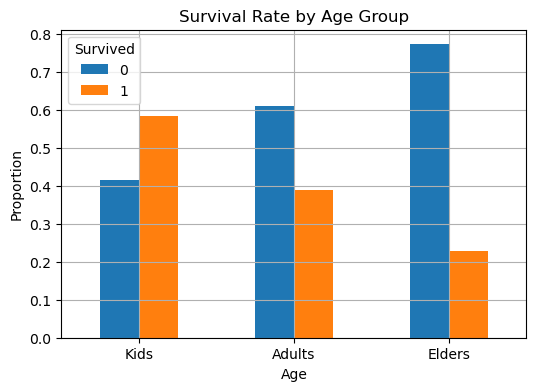

In [178]:
bins = [0, 14, 60, 120]   # 0-12: Kids, 13-60: Adults, 61+: Elders
labels = ['Kids', 'Adults', 'Elders']
age_group = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
survival_by_agegroup = df.groupby(age_group)['Survived'].value_counts(normalize=True).unstack()
display(survival_by_agegroup)


# Plot
survival_by_agegroup.plot(kind='bar', figsize=(6,4), rot=0, grid=True)
plt.title('Survival Rate by Age Group')
plt.ylabel('Proportion')
plt.show()

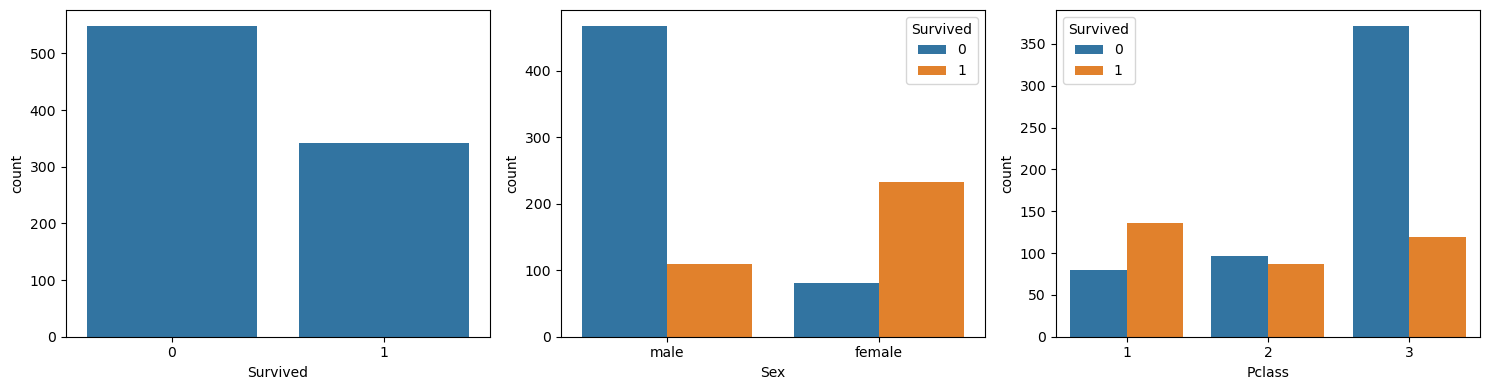

In [179]:
# Step 2.3 - Visual inspection of class balance and key categorical relationships
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(data=df, x='Survived', ax=axes[0])
sns.countplot(data=df, x='Sex', hue='Survived', ax=axes[1])
sns.countplot(data=df, x='Pclass', hue='Survived', ax=axes[2])
plt.tight_layout()
plt.show()


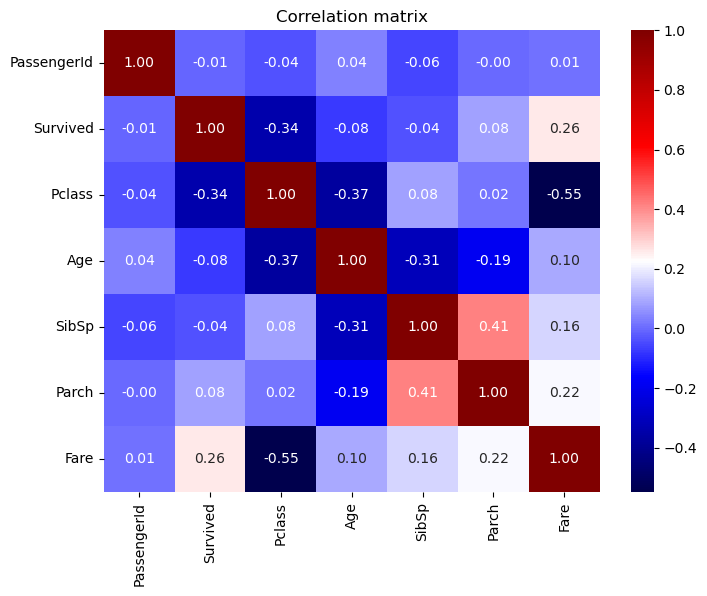

In [180]:
# Step 2.5 - correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='seismic', fmt=".2f")
plt.title("Correlation matrix")
plt.show()


Step 3 - Feature Engineering

In [181]:
# Step 3.1 - Extract Title from Name
df['Title'] = df['Name'].str.extract(r', (\w+)\.', expand=False)
df['Title'].unique()



array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', nan, 'Jonkheer'],
      dtype=object)

In [182]:
df['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Don           1
Mme           1
Ms            1
Sir           1
Lady          1
Capt          1
Jonkheer      1
Name: count, dtype: int64

In [183]:
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})
df['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       22
Name: count, dtype: int64

In [184]:
# Step 3.2 - Family size and alone indicator
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df[['FamilySize','IsAlone']].head()


,FamilySize,IsAlone
0,2,0
1,2,0
2,1,1
3,2,0
4,1,1


In [185]:
# Step 3.3 - Extract Deck from Cabin
df['Deck'] = df['Cabin'].str[0]
df['Deck'] = df['Deck'].fillna('U')  # 'U' for unknown
df['Deck'].value_counts()


Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [186]:
# Drop columns we won't use directly
df.drop(columns=['PassengerId','Name','Cabin','Ticket'], inplace=True)
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,Deck
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,0,U
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0,C
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,1,U
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0,C
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,1,U


In [187]:
# Separate features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Identify categorical and numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numeric features:", list(num_cols))
print("Categorical features:", list(cat_cols))


Numeric features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
Categorical features: ['Sex', 'Embarked', 'Title', 'Deck']


In [188]:
# Numeric transformer: impute + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier  

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE), 
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    results[name] = {"Accuracy": acc, "F1": f1, "ROC-AUC": roc}

# Display comparison
results_df = pd.DataFrame(results).T.sort_values(by="ROC-AUC", ascending=False)
display(results_df)


,Accuracy,F1,ROC-AUC
Logistic Regression,0.843575,0.787879,0.872859
Gradient Boosting,0.804469,0.724409,0.843478
Random Forest,0.804469,0.732824,0.825823
Decision Tree,0.782123,0.702290,0.748353


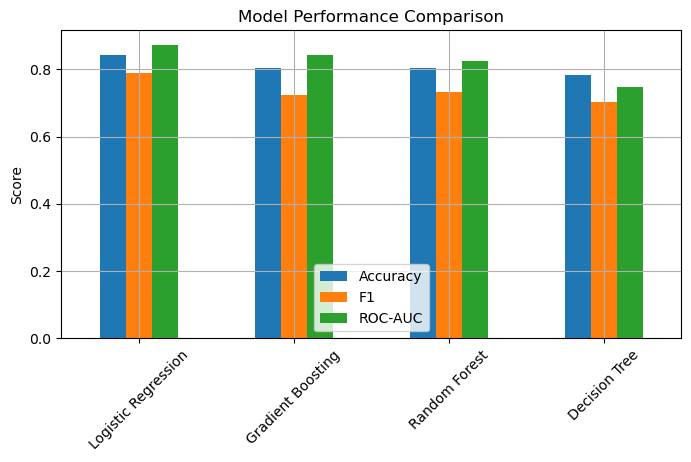

In [190]:
results_df.plot(kind='bar', figsize=(8,4), title="Model Performance Comparison")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()


Hyperparameter Tuning


In [191]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

# Create pipeline again
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Grid search
grid_search = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)


Best parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best ROC-AUC: 0.868135508691935


Final Accuracy: 0.8156424581005587
Final F1 Score: 0.7480916030534351
Final ROC-AUC: 0.866798418972332

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



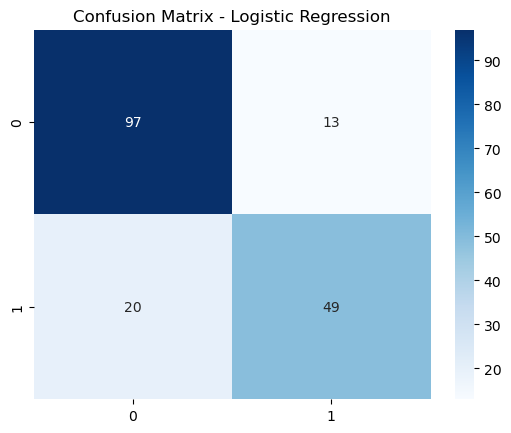

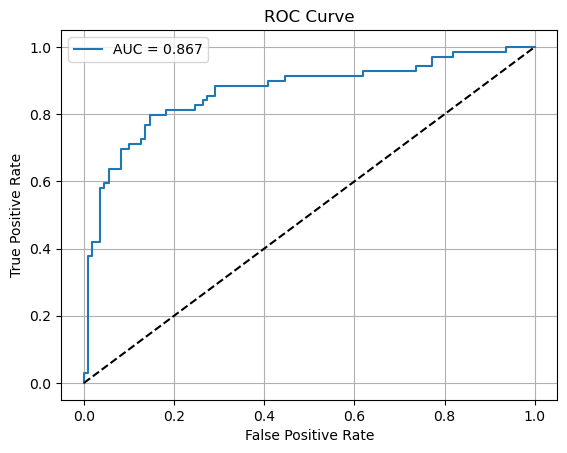

In [192]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final F1 Score:", f1_score(y_test, y_pred))
print("Final ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


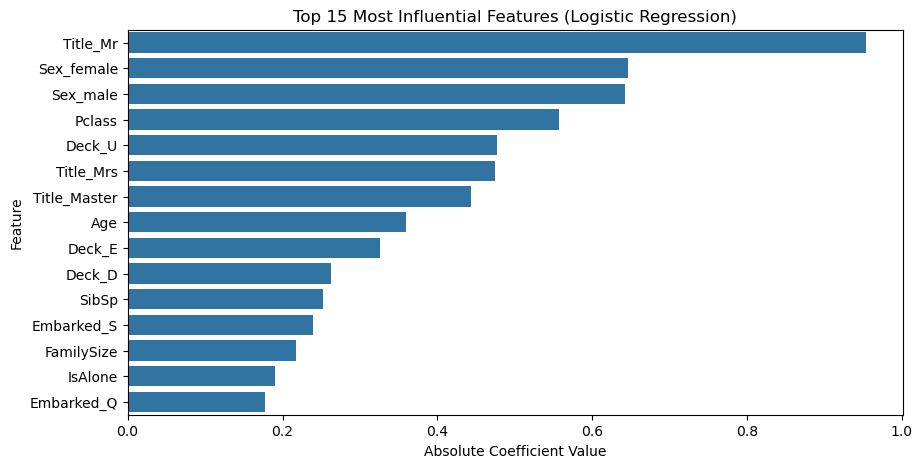

In [193]:
# Get feature names after one-hot encoding
ohe = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_features = list(ohe.get_feature_names_out(cat_cols))
all_features = list(num_cols) + encoded_features

# Get coefficients
coefs = best_model.named_steps['model'].coef_[0]
importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefs})
importance['abs_coef'] = importance['Coefficient'].abs()
importance.sort_values('abs_coef', ascending=False, inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(data=importance.head(15), x='abs_coef', y='Feature')
plt.title('Top 15 Most Influential Features (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.show()


In [194]:
import streamlit as st
import joblib
import pandas as pd

st.title("🛳️ Titanic Survival Predictor")

model = joblib.load("titanic_logreg_model.pkl")

# User inputs
sex = st.selectbox("Sex", ["male", "female"])
pclass = st.selectbox("Passenger Class", [1,2,3])
age = st.slider("Age", 1, 80, 25)
fare = st.slider("Fare", 0, 500, 32)
sibsp = st.number_input("Siblings/Spouses Aboard", 0, 8, 0)
parch = st.number_input("Parents/Children Aboard", 0, 6, 0)
embarked = st.selectbox("Embarked", ["S", "C", "Q"])

# Prepare single-row DataFrame (with same columns as training)
input_data = pd.DataFrame({
    'Pclass':[pclass], 'Sex':[sex], 'Age':[age], 'Fare':[fare],
    'SibSp':[sibsp], 'Parch':[parch], 'Embarked':[embarked],
    # You can add engineered fields like Title, Deck, etc. manually or via your pipeline
})

if st.button("Predict Survival"):
    pred = model.predict(input_data)
    st.success("🎉 Survived!" if pred[0]==1 else "😢 Did not survive.")


2026-02-02 08:37:52.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.345 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.347 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 08:37:52.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [171]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


Run - streamlit run titanic_survive.py

in terminal for interactive experience


In [172]:
pip install shap
